# Final Project Report
## Noam Siegel
### Physiological Signal Processing, Ben Gurion University
 #### 367-2-6351



In [160]:
%load_ext autoreload
%autoreload 2

import itertools

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE

from msc.config import get_config
from msc.dataset import RawDataset, PSPDataset
from msc.dataset.dataset import get_datasets_df
from scripts.psp.analysis.data_visualizations import plot_pca_projection
from scripts.psp.analysis.imshow_dataset import plot_feature_window
from scripts.psp.analysis.plot_feature_window import plot_results_score
from scripts.psp.build_dataset import build_dataset
from scripts.psp.training import classifier_comparison
from scripts.psp.analysis.plot_feature_window import plot_results_time


UsageError: Line magic function `%` not found.


## Load configurations

In [8]:
config = get_config()
config

{'PATH': {'LOCAL': {'RAW_DATASET': 'C:\\raw_data\\epilepsiae',
   'RESULTS': 'C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results',
   'PSP_DATASET': 'C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results\\epilepsiae'},
  'BGUCLUSTER': {'RAW_DATASET': '/cs_storage/noamsi/raw_data/epilepsiae/',
   'RESULTS': '/cs_storage/noamsi/results/',
   'PSP_DATASET': '/cs_storage/noamsi/results/epilepsiae/'},
  'MIRIAM': {'RAW_DATASET': '\\\\132.72.65.115\\epilepsy_data\\Epilepsiea\\raw_data'}},
 'TASK': {'PICKS': 'one_channel',
  'RESAMPLE': '256',
  'PREICTAL_MIN_DIFF_HOURS': '1',
  'INTERICTAL_MIN_DIFF_HOURS': '4',
  'PREICTAL_LABEL': '0',
  'INTERICTAL_LABEL': '1'},
 'RESULTS': {'LOCAL': None,
  'BGUCLUSTER': {'RESULTS_DIR': '/cs_storage/noamsi/results'}},
 'DATASET': 'epilepsiae',
 'RAW_MACHINE': 'MIRIAM',
 'RESULTS_MACHINE': 'LOCAL'}

## Get Raw dataset

In [9]:
raw_dataset = RawDataset(f"{config['PATH']['MIRIAM']['RAW_DATASET']}")
raw_dataset.data_df

,package,patient,admission,recording,fname,meas_date,end_date,time_zone,sfreq,nsamples,time_hours,nchan,ch_names,highpass,lowpass,fpath,seizure_table,num_seizures
0,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_018.data,2009-05-20 08:27:43,2009-05-20 08:34:56,UTC,400.0,173550,0.120521,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
1,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_012.data,2009-05-20 02:53:25,2009-05-20 03:49:08,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
2,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_010.data,2009-05-20 01:01:59,2009-05-20 01:57:42,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
3,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_004.data,2009-05-19 19:27:41,2009-05-19 20:23:24,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
4,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_003.data,2009-05-19 18:31:58,2009-05-19 19:27:41,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17519,CO,pat_7800,adm_780100,rec_78010100,78010100_0057.data,2011-09-16 09:38:24,2011-09-16 11:38:24,UTC,1024.0,7372896,2.000026,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
17520,CO,pat_7800,adm_780100,rec_78010100,78010100_0037.data,2011-09-15 05:55:27,2011-09-15 07:24:03,UTC,1024.0,5443712,1.476701,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,1
17521,CO,pat_7800,adm_780100,rec_78010100,78010100_0061.data,2011-09-16 16:18:40,2011-09-16 17:33:55,UTC,1024.0,4623808,1.254288,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
17522,CO,pat_7800,adm_780100,rec_78010100,78010100_0042.data,2011-09-15 14:45:14,2011-09-15 15:20:22,UTC,1024.0,2159584,0.585825,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0


## Select random data file

In [10]:
data_row = raw_dataset.data_df.query("package == 'surfCO' and patient == 'pat_3500'").sample(1)
data_row.transpose()

,10614
package,surfCO
patient,pat_3500
admission,adm_350100
recording,rec_35010100
fname,35010100_0007.data
meas_date,2009-11-16 22:00:35
end_date,2009-11-17 00:00:35
time_zone,UTC
sfreq,1024.0
nsamples,7372832


## Plot raw data

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, Fp2, F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, P7, P3, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2009-11-16 22:00:35 UTC
 nchan: 32
 projs: []
 sfreq: 1024.0 Hz
>


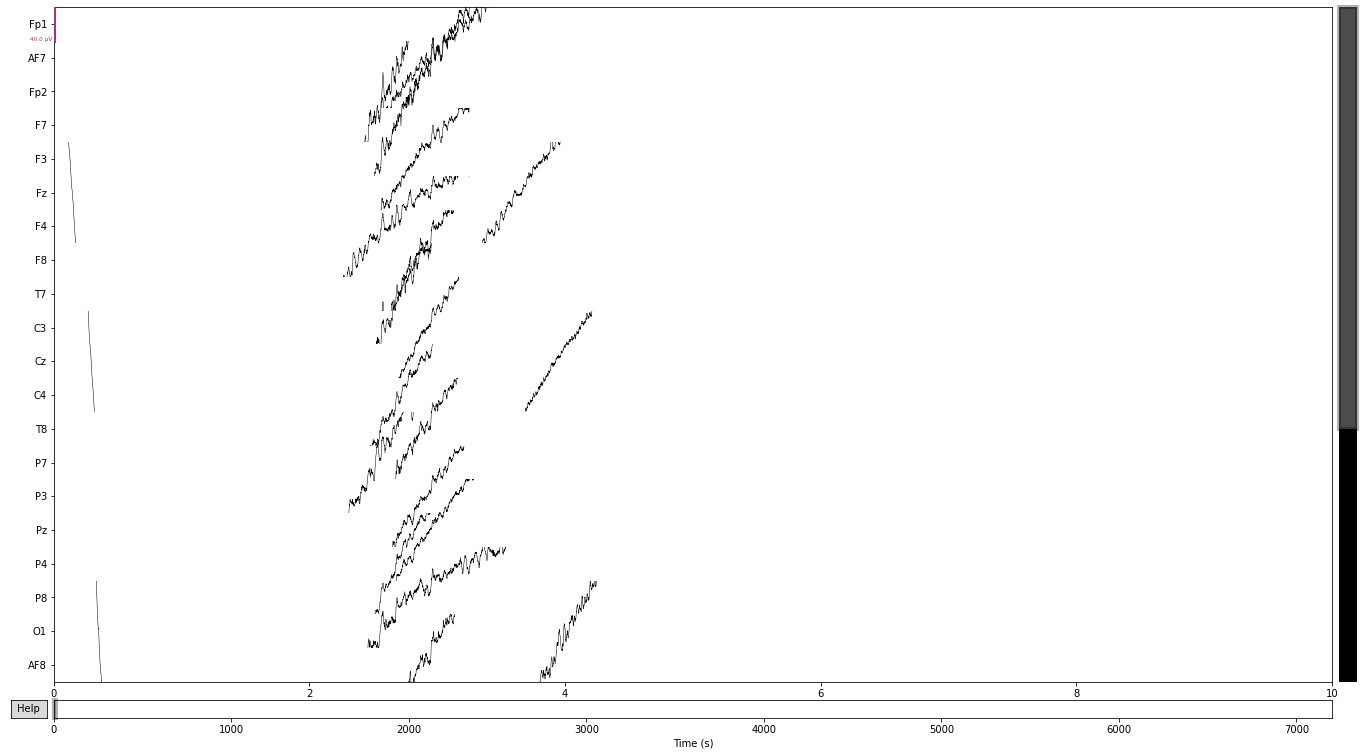

In [11]:
raw = raw_dataset.get_raw(data_row)
print(raw.info)
raw.plot();

## Feature Extraction
### Build Dataset (Demo)

In [30]:
available_features = ['max_cross_corr', 'phase_lock_val', 'nonlin_interdep', 'time_corr', 'spect_corr']
selected_feature = available_features[0]
package = 'surfCO'
selected_patient = 'pat_3500'

raw_args = ['--dev', '-p', selected_patient, '-f', selected_feature]

build_dataset.main(raw_args)

Starting build_dataset.py with fast_dev_mode=True at time 20211218T235331
WARNING! fast_dev_mode=True !!! Results are incomplete.
dumping results to C:\Users\noam\Repositories\noamsgl\msc\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211218T235331
getting selected_func='max_cross_corr' for patient='pat_3500' from package='surfCO'
len(preictal_intervals)=5
len(interictal_intervals)=6
len(preictal_window_intervals)=2
len(interictal_window_intervals)=2


loading patient data: 100%|██████████| 61/61 [01:23<00:00,  1.38s/it]


len(preictal_raws)=2
starting to extract features for preictal raws
dumping window_id=0 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211218T235331/window_0.pkl'
dumping window_id=1 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211218T235331/window_1.pkl'


loading patient data: 100%|██████████| 61/61 [02:00<00:00,  1.97s/it]


[<RawNicolet | 35010100_0000.data, 19 x 76801 (300.0 s), ~11.2 MB, data loaded>, <RawNicolet | 35010100_0000.data, 19 x 76801 (300.0 s), ~11.2 MB, data loaded>]
starting to extract features for interictal raws
dumping window_id=2 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211218T235331/window_2.pkl'
dumping window_id=3 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211218T235331/window_3.pkl'
saving samples_df to samples_df_path='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211218T235331/dataset.csv'


## Load index of existing datasets

In [23]:
datasets_df = get_datasets_df()
datasets_df

,feature_name,patient_name,data_dir
0,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
1,max_cross_corr,pat_3700,C:\Users\noam\Repositories\noamsgl\msc\results...
2,max_cross_corr,pat_7200,C:\Users\noam\Repositories\noamsgl\msc\results...
3,phase_lock_val,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
4,phase_lock_val,pat_3700,C:\Users\noam\Repositories\noamsgl\msc\results...
5,phase_lock_val,pat_7200,C:\Users\noam\Repositories\noamsgl\msc\results...
6,spect_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
7,spect_corr,pat_3700,C:\Users\noam\Repositories\noamsgl\msc\results...
8,spect_corr,pat_7200,C:\Users\noam\Repositories\noamsgl\msc\results...
9,time_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...


## Visualize Features
Assumes many datasets have been built

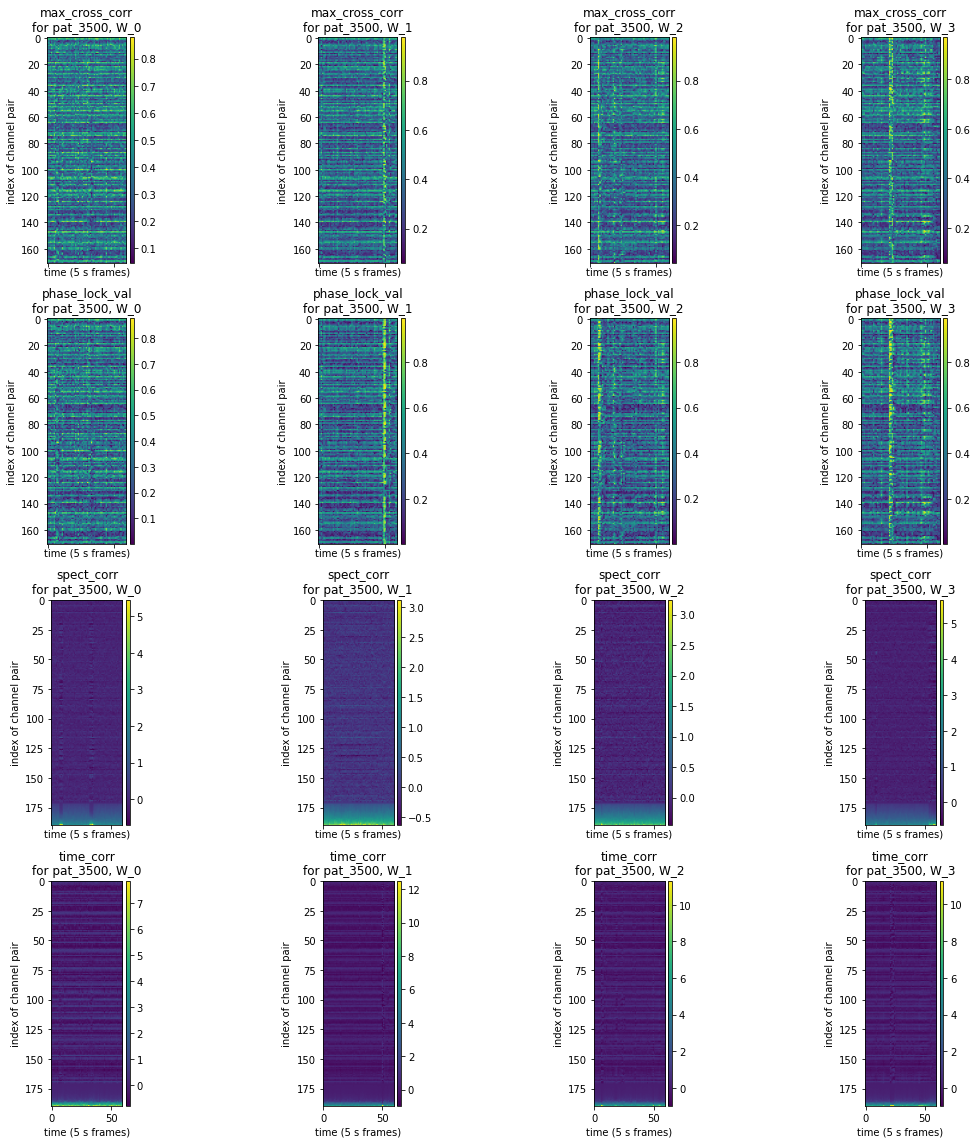

In [55]:
patients_datasets_df = datasets_df.query(f"selected_patient == '{selected_patient}'").reset_index()
nrows = len(patients_datasets_df)
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * nrows, 4 * ncols), sharex=True, sharey=False)
for i in range(nrows):
    dataset = patients_datasets_df.loc[i]
    psp_dataset = PSPDataset(dataset.data_dir)
    X, labels = psp_dataset.get_X(), psp_dataset.get_labels(format='desc')
    for j in range(ncols):
        plot_feature_window(X[j].reshape(-1, 60), patient_name=selected_patient, window_name=f'W_{j}', feature_name=dataset.feature_name, ax=axes[i, j])
plt.tight_layout()
plt.show()


## Visualize Datasets
We show a PCA projection to 2 dimensions for 12 different datasets.

plotting pca for feature_name                                       max_cross_corr
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 0, dtype: object
plotting pca for feature_name                                       max_cross_corr
patient_name                                             pat_3700
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 1, dtype: object
plotting pca for feature_name                                       max_cross_corr
patient_name                                             pat_7200
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 2, dtype: object
plotting pca for feature_name                                       phase_lock_val
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 3, dtype: object
plotting pca for feature_name                   

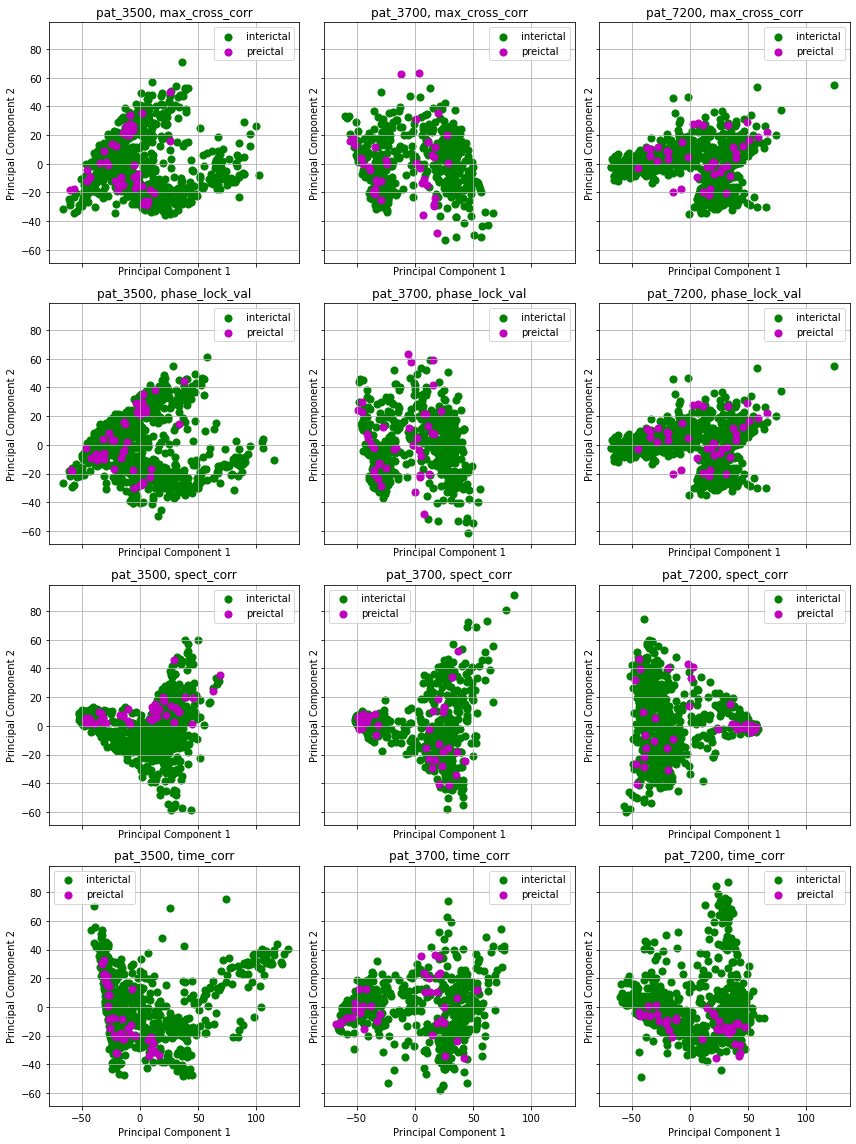

In [56]:
fig, axes = plt.subplots(4, 3, figsize=(12, 16), sharex=True, sharey=True)
for i, ax in enumerate(fig.axes):
    plot_pca_projection(datasets_df.sort_values(by=['feature_name', 'patient_name'], ignore_index=True).loc[i], ax=ax)
plt.tight_layout()
plt.show()


## Train classifier on multiple feature datasets at once

In [60]:
feature_names = (
    'max_cross_corr',
    'phase_lock_val',
    'spect_corr',
    'time_corr'
)

patient_names = ['pat_3500',
                 'pat_3700',
                 'pat_7200'
                 ]

classifier_names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]
results = classifier_comparison.main(save_to_disk=False,
                                     feature_names=feature_names,
                                     patient_names=patient_names,
                                     classifier_names=classifier_names)

iterating datasets:   0%|          | 0/2 [00:00<?, ?it/s]

beginning ds=feature_name                                       max_cross_corr
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 0, dtype: object



iterating datasets:  50%|█████     | 1/2 [02:39<02:39, 159.55s/it]

beginning ds=feature_name                                       phase_lock_val
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 3, dtype: object



iterating datasets: 100%|██████████| 2/2 [05:08<00:00, 154.46s/it]


In [146]:
results = results.set_index(['patient_name','feature_name','classifier_name'])
results

fold  fit_time  score_time  \
patient_name feature_name   classifier_name                                 
pat_3500     max_cross_corr Nearest Neighbors     0  0.013998    0.044000   
                            Nearest Neighbors     1  0.011030    0.046966   
                            Nearest Neighbors     2  0.012998    0.065001   
                            Nearest Neighbors     3  0.010999    0.075004   
                            Nearest Neighbors     4  0.075999    0.125999   
                            Decision Tree         0  7.179443    2.681021   
                            Decision Tree         1  6.922996    2.367000   
                            Decision Tree         2  7.789036    2.947000   
                            Decision Tree         3  7.090999    2.211998   
                            Decision Tree         4  6.060002    2.078014   
                            Random Forest         0  9.194083    4.824001   
                            Random Forest         1  8.224035    4.334965   
                            Random Forest         2  7.430036    4.478968   
                            Random Forest         3  8.279005    4.836131   
                            Random Forest         4  8.000432    4.936732   
                            Naive Bayes           0  0.782195    0.005983   
                            Naive Bayes           1  0.578448    0.004948   
                            Naive Bayes           2  0.743985    0.005999   
                            Naive Bayes           3  0.594137    0.005950   
                            Naive Bayes           4  0.990050    0.004988   
                            QDA                   0  0.023965    0.008034   
                            QDA                   1  0.023947    0.008032   
                            QDA                   2  0.021966    0.008034   
                            QDA                   3  0.022982    0.007999   
                            QDA                   4  0.031009    0.014025   
             phase_lock_val Nearest Neighbors     0  0.012001    0.033003   
                            Nearest Neighbors     1  0.011044    0.033989   
                            Nearest Neighbors     2  0.016012    0.043951   
                            Nearest Neighbors     3  0.012004    0.036034   
                            Nearest Neighbors     4  0.013962    0.036003   
                            Decision Tree         0  6.439965    2.103998   
                            Decision Tree         1  5.810999    1.937999   
                            Decision Tree         2  6.063001    2.533000   
                            Decision Tree         3  6.376999    2.187001   
                            Decision Tree         4  6.002001    1.955999   
                            Random Forest         0  7.165767    4.047520   
                            Random Forest         1  7.614002    4.451999   
                            Random Forest         2  7.878035    3.959964   
                            Random Forest         3  8.099001    4.468999   
                            Random Forest         4  7.974034    4.248965   
                            Naive Bayes           0  1.033966    0.006033   
                            Naive Bayes           1  0.989001    0.006034   
                            Naive Bayes           2  1.041003    0.005997   
                            Naive Bayes           3  1.038964    0.006041   
                            Naive Bayes           4  1.047003    0.007967   
                            QDA                   0  0.027033    0.009964   
                            QDA                   1  0.026004    0.010033   
                            QDA                   2  0.028998    0.008004   
                            QDA                   3  0.027001    0.011036   
                            QDA                   4  0.027961    0.009001   

                                          

In [150]:
results.groupby(['patient_name','feature_name','classifier_name']).mean().drop(columns='fold')

fit_time  score_time  \
patient_name feature_name   classifier_name                           
pat_3500     max_cross_corr Decision Tree      7.008495    2.457006   
                            Naive Bayes        0.737763    0.005574   
                            Nearest Neighbors  0.025005    0.071394   
                            QDA                0.024774    0.009225   
                            Random Forest      8.225518    4.682159   
             phase_lock_val Decision Tree      6.138593    2.143599   
                            Naive Bayes        1.029987    0.006415   
                            Nearest Neighbors  0.013005    0.036596   
                            QDA                0.027399    0.009608   
                            Random Forest      7.746168    4.235490   

                                               test_precision  test_recall  \
patient_name feature_name   classifier_name                                  
pat_3500     max_cross_corr Decision Tree            0.950192     1.000000   
                            Naive Bayes              0.951952     0.908197   
                            Nearest Neighbors        0.954623     0.963934   
                            QDA                      0.950192     1.000000   
                            Random Forest            0.950192     1.000000   
             phase_lock_val Decision Tree            0.950192     1.000000   
                            Naive Bayes              0.949420     0.924590   
                            Nearest Neighbors        0.952055     0.970492   
                            QDA                      0.950192     1.000000   
                            Random Forest            0.950192     1.000000   

                                               test_roc_auc  
patient_name feature_name   classifier_name                  
pat_3500     max_cross_corr Decision Tree          0.825956  
                            Naive Bayes            0.504098  
                            Nearest Neighbors      0.606831  
                            QDA                    0.591667  
                            Random Forest          0.500000  
             phase_lock_val Decision Tree          0.739071  
                            Naive Bayes            0.496175  
                            Nearest Neighbors      0.603279  
                            QDA                    0.461749  
                            Random Forest          0.500000

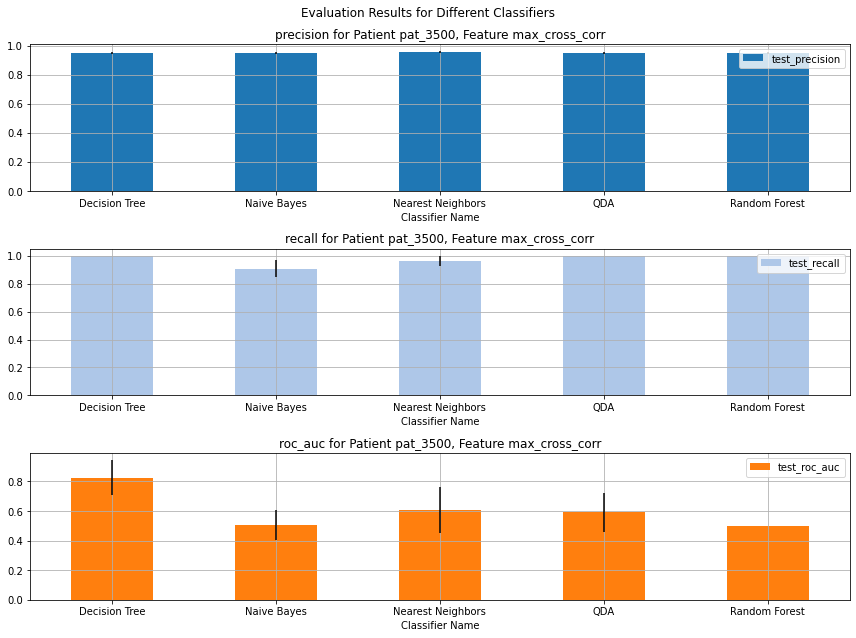

In [111]:
fig, axes = plt.subplots(3, figsize=(12, 9), sharex=False)
patient_results = results.loc[(results['patient_name'] == selected_patient) & (results['feature_name'] == selected_feature)]

cs = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5']

colors = itertools.cycle(cs)

fig.suptitle('Evaluation Results for Different Classifiers')
for i, score in enumerate(('precision', 'recall', 'roc_auc')):
    plot_results_score(patient_results, patient_name=selected_patient, feature_name=selected_feature, score=score, ax=axes[i], logy=False, color=next(colors))
plt.tight_layout()

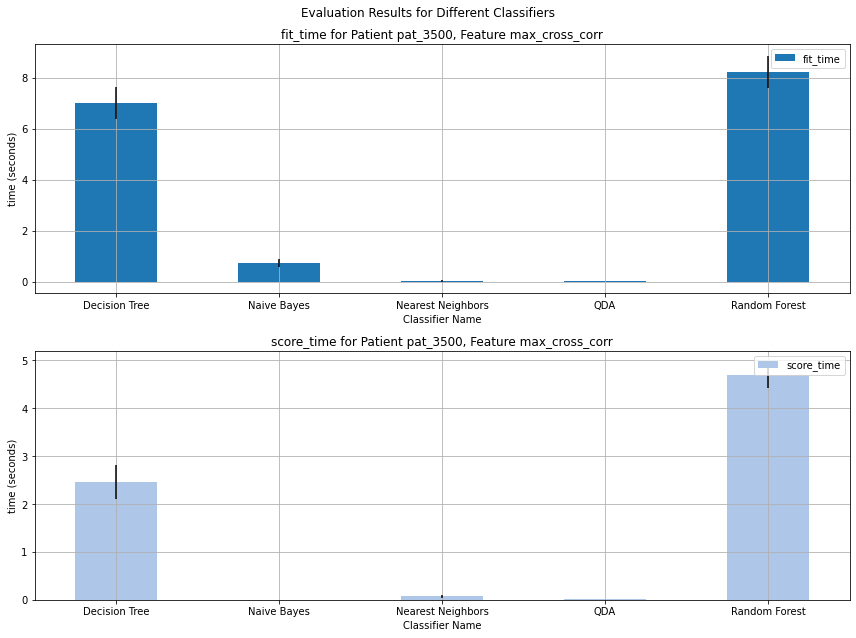

In [126]:

fig, axes = plt.subplots(2, figsize=(12, 9), sharex=False)
patient_results = results.loc[(results['patient_name'] == selected_patient) & (results['feature_name'] == selected_feature)]

colors = itertools.cycle(cs)

fig.suptitle('Evaluation Results for Different Classifiers')
for i, time_col in enumerate(('fit_time', 'score_time')):
    plot_results_time(patient_results, patient_name=selected_patient, feature_name=selected_feature, time_col=time_col, ax=axes[i], logy=False, color=next(colors))
plt.tight_layout()

## Variable Selection

In [165]:
estimator = results.loc['pat_3500', 'max_cross_corr', 'Random Forest', results['fold'] == 0].estimator.item()
estimator

SVC(C=1, gamma=2)

In [167]:
estimator = results.loc['pat_3500', 'max_cross_corr', 'QDA', results['fold'] == 0].estimator.item()
selector = RFE(estimator, n_features_to_select=60 * 10)
selector = selector.fit(X, labels)

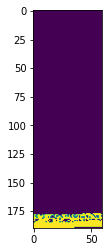

In [171]:
plt.imshow(selector.support_.reshape(-1,60))